In [ ]:
!jupyter nbconvert --to script Visualization_Final.ipynb

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# 1. Data Visualization

## 1.1 Single Policy Analysis

In [3]:
# Load in the file you want to analyze
# Single Policy experiments:
# 200ScenariosRWSPolicies
# 1000ScenariosBaseCase

# Multiple policy experiments
# 1000ScenariosBaseRfRDikePolicies
# 200Scenarios50Policies
# 400Scenarios75Policies

results = utilities.load_results('outcomes/1000ScenariosBaseCase.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
# results = results.apply(pd.to_numeric)
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\outcomes\1000ScenariosBaseCase.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,64.0,341.707998,10.0,0.008967,329.059434,1.0,0.671443,46.836038,1.0,0.541864,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0
1,49.0,270.516534,1.0,0.389864,64.116779,1.0,0.458602,211.600292,1.5,0.030226,...,0,1.053592,0.0,0,0.0,0.0,0,0.0,0.0,0.0
2,109.0,217.092157,1.0,0.720433,119.844801,1.5,0.445405,332.843340,10.0,0.123183,...,0,1.091069,0.0,0,0.0,0.0,0,0.0,0.0,0.0
3,106.0,314.195207,1.0,0.000931,149.934556,10.0,0.203409,177.126583,1.5,0.900999,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0
4,123.0,331.097660,1.5,0.138750,275.055604,1.0,0.296295,172.209395,1.5,0.888339,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0


In [4]:
results["policy"].unique()

[base case]
Categories (1, object): [base case]

In [ ]:
# Select the policy name for multiple policy experiments otherwise ignore
# Replace the df (results) as parameter of the functions with policy_df
# policy_df = results[results["policy"] == "RfR only"]

### 1.1.1 Histograms of the outcomes per location and timestep

In [ ]:
def histogram_maker(results, outcome, n = 3):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']


    print("Plot " + str(outcome) + "(Histogram)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(10, 3))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            # ax.hist(results[str(place) + "_Expected Annual Damage " + str(step)], color=colors[i])
            ax.hist(results[str(place) + "_" + str(outcome) + " " + str(step)], color=colors[i])
            ax.set_xlim(left = 0)
            ax.set_title(place)

        plt.tight_layout()
        plt.show()

In [ ]:
histogram_maker(results, "Expected Annual Damage")
histogram_maker(results, "Expected Number of Deaths")

### 1.1.2 Mean of the outcomes per location and timestep

In [ ]:
mean_outcomes_df = results.iloc[:, 52:].apply(np.mean, axis = 0)

In [5]:
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def mean_outcomes(results):
    # Get the mean for all the results across the scenarios to have a quick look at significant locations
    mean_outcomes_df = results.iloc[:, 52:].apply(np.mean, axis = 0)
    
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    outcomes = ["Expected Annual Damage", "Expected Number of Deaths", "Dike Investment Costs", "RfR Total Costs"]
    x = [0, 1, 2]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True)
    axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

    for ax, criteria in zip(axes, outcomes):
        for step in x:
            for place in locations:
                if criteria == "RfR Total Costs":
                    ax.plot(step, mean_outcomes_df[[str(criteria) + " " + str(step)]].values[0], 'ro', c ='y')
                else:
                    if place == "A.1":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="b", label = "A.1")
                    elif place == "A.2":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="r", label = "A.2")
                    elif place == "A.3":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="g", label = "A.3")
                    elif place == "A.4":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="m", label = "A.4")
                    elif place == "A.5":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="c", label = "A.5")

        ax.set_xlabel("Time Steps")
        ax.set_ylabel(criteria)
        ax.set_title(str(criteria) + " over the locations", y = 1.1)
        legend_without_duplicate_labels(ax)


    plt.tight_layout()
    plt.show()

No handles with labels found to put in legend.


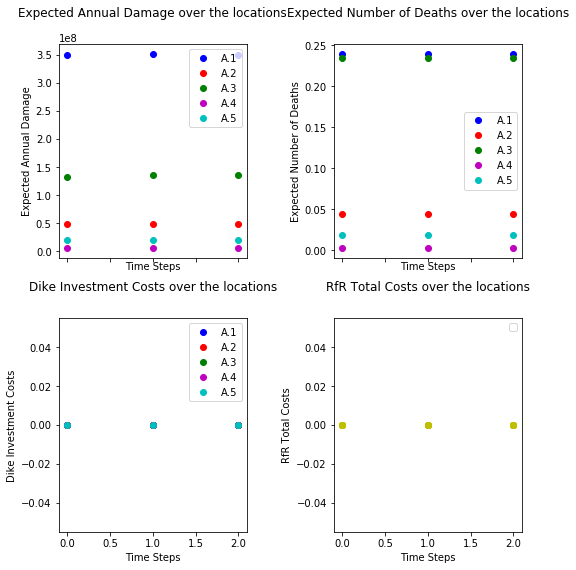

In [6]:
mean_outcomes(results)

## 1.2 Multiple Policies Analysis

In [ ]:
results = utilities.load_results('outcomes/400Scenarios75Policies.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results["policy"] = results["policy"].astype(str)
results.head()

In [ ]:
outcomes

In [ ]:
def aggregate_outcomes(results, outcome):
    list_outcomes_columns = []
    
    for i in results.columns:
        if outcome in i:
            list_outcomes_columns.append(i)
            
    results["Total " + str(outcome)] = results[list_outcomes_columns].sum(axis = 1)

In [ ]:
aggregate_outcomes(results, "Expected Number of Deaths")
aggregate_outcomes(results, "Expected Annual Damage")
aggregate_outcomes(results, "Dike Investment Costs")
aggregate_outcomes(results, "RfR Total Costs")
aggregate_outcomes(results, "Expected Evacuation Costs")

In [ ]:
results.head()

In [ ]:
y = results.iloc[:, -5:]

In [ ]:
fs = feature_scoring.get_feature_scores_all(x, y)

In [ ]:
fig = plt.subplots(figsize=(10,10))
sns.heatmap(fs, cmap='viridis', annot=True, )
plt.show()

### 1.2.1 Scatterplot over locations, time steps, and policies

In [ ]:
def scatter_maker(results, outcome, n = 3):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    
    print("Plot " + str(outcome) + "(Scatterplot)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(15, 4))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            plt.sca(ax)
            
            if i != 4:
                ax = sns.scatterplot(x="scenario", y=(str(place) + "_" + str(outcome) + " " + str(step)), hue="policy",
                          data=results, legend = False)
            else:
                ax = sns.scatterplot(x="scenario", y=(str(place) + "_" + str(outcome) + " " + str(step)), hue="policy",
                          data=results)
                ax.legend(loc = 'upper right', bbox_to_anchor=(2, 1), fontsize = 8)

            ax.set_xlim(left = 0)
            ax.set_title(place)

#         plt.tight_layout()
        plt.show()
#         plt.legend()

In [ ]:
scatter_maker(results, "Expected Annual Damage")
scatter_maker(results, "Expected Number of Deaths")

### 1.2.2 Pairplot

In [ ]:
def pairplot_maker(results, location, n = 3):
    list_loc = []

    for i in results.columns:
        if location in i:
            list_loc.append(i)
            
    # TO-DO:        
    # Add other uncertentainties which do not have A.1 in name, like discount rate and flow.. 
    list_loc.append("policy")
    
    sns.pairplot(results[list_loc], hue='policy',  vars=results[list_loc].iloc[:, 6:-1].keys(), )
    plt.tight_layout()
    plt.show()

In [ ]:
pairplot_maker(results, "A.1")
# pairplot_maker(results, "A.2")
# pairplot_maker(results, "A.3")
# pairplot_maker(results, "A.4")
# pairplot_maker(results, "A.5")